In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
train_dir='/home/chirag/medical_classification_project/Data/balanced_train'#we are using balanced train data
test_dir='/home/chirag/medical_classification_project/Data/test'
val_dir='/home/chirag/medical_classification_project/Data/val'

print("Train: ",os.listdir(train_dir))
print("Validation: ",os.listdir(val_dir))
print("Test: ",os.listdir(test_dir))

Train:  ['PNEUMONIA', 'NORMAL']
Validation:  ['PNEUMONIA', 'NORMAL']
Test:  ['PNEUMONIA', 'NORMAL']


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size=(224,224)
batch_size=32
traingen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    brightness_range=[0.2,1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
testgen=ImageDataGenerator(rescale=1./255)
valgen=ImageDataGenerator(rescale=1./255)

In [5]:
traindata=traingen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)
valdata=valgen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)
testdata=testgen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

Found 2600 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Found 624 images belonging to 2 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-6:]:
    layer.trainable = True

I0000 00:00:1739981511.438155   10501 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4302 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
model=Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,043,137 (57.39 MB)

 Trainable params: 9,767,681 (37.26 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.00001),loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)
lr_scheduler=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
history=model.fit(traindata,validation_data=valdata,epochs=50,callbacks=[lr_scheduler,early_stop])

/home/chirag/medical_classification_project/medical_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1739981518.505794   10628 service.cc:148] XLA service 0x7f1504023890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739981518.505817   10628 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-02-19 21:41:58.541704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739981518.851613   10628 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-19 21:41:59.723949: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2006', 24 bytes spill stores, 24 bytes spill loads

2025-02-19 21:41:59.940554: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

 1/82 ━━━━━━━━━━━━━━━━━━━━ 25:40 19s/step - accuracy: 0.4688 - loss: 0.7454

I0000 00:00:1739981535.666756   10628 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 61s 515ms/step - accuracy: 0.5925 - loss: 0.6767 - val_accuracy: 0.5625 - val_loss: 0.6017 - learning_rate: 1.0000e-05
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 352ms/step - accuracy: 0.7642 - loss: 0.5040 - val_accuracy: 0.8125 - val_loss: 0.4497 - learning_rate: 1.0000e-05
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 350ms/step - accuracy: 0.8783 - loss: 0.2912 - val_accuracy: 0.9375 - val_loss: 0.2213 - learning_rate: 1.0000e-05
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 345ms/step - accuracy: 0.9089 - loss: 0.2274 - val_accuracy: 1.0000 - val_loss: 0.1794 - learning_rate: 1.0000e-05
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 350ms/step - accuracy: 0.9302 - loss: 0.1841 - val_accuracy: 0.9375 - val_loss: 0.1184 - learning_rate: 1.0000e-05
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.9342 - loss: 0.1794 - val_accuracy: 0.9375 - val_loss: 0.1695 - learning_rate: 1.0000e-05
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.93

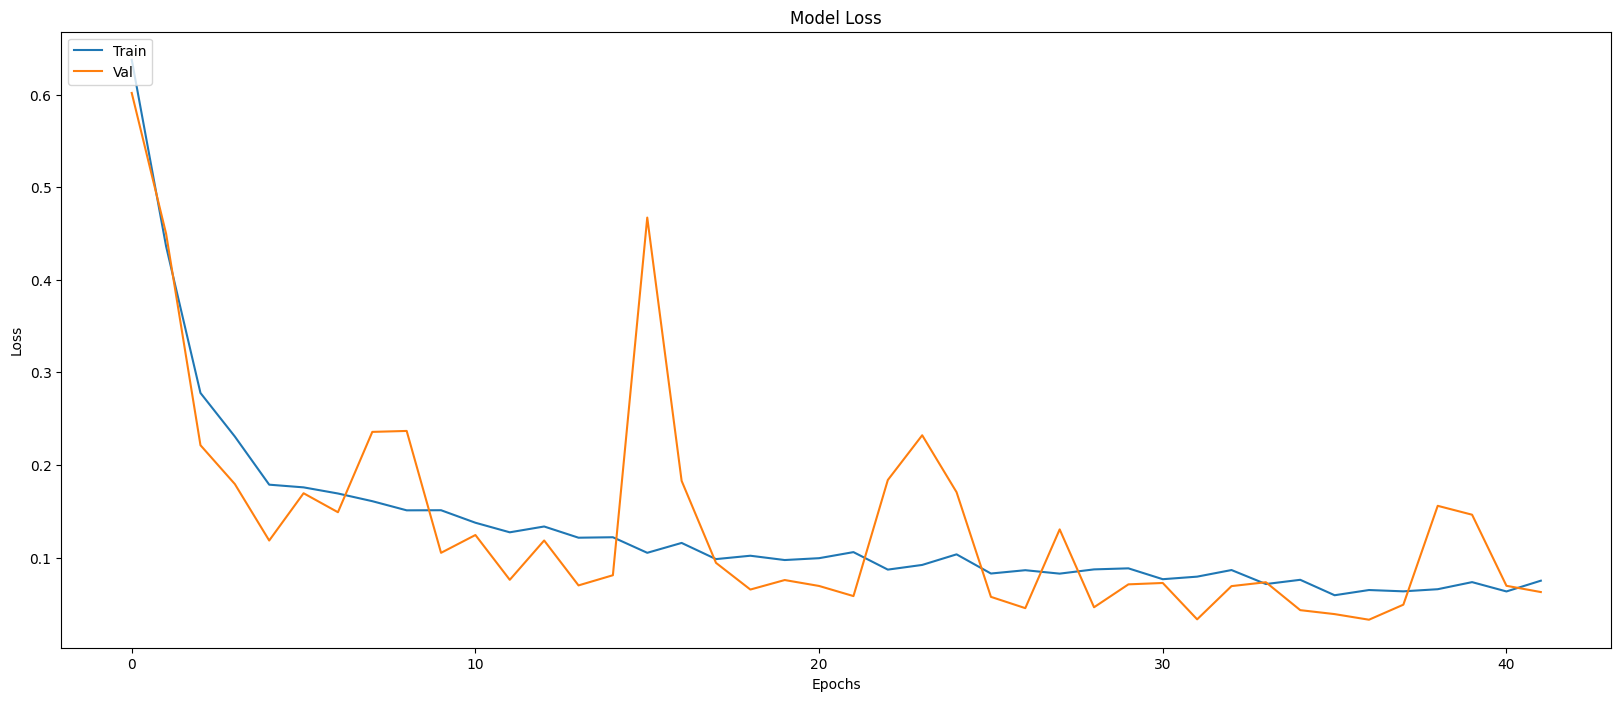

In [12]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

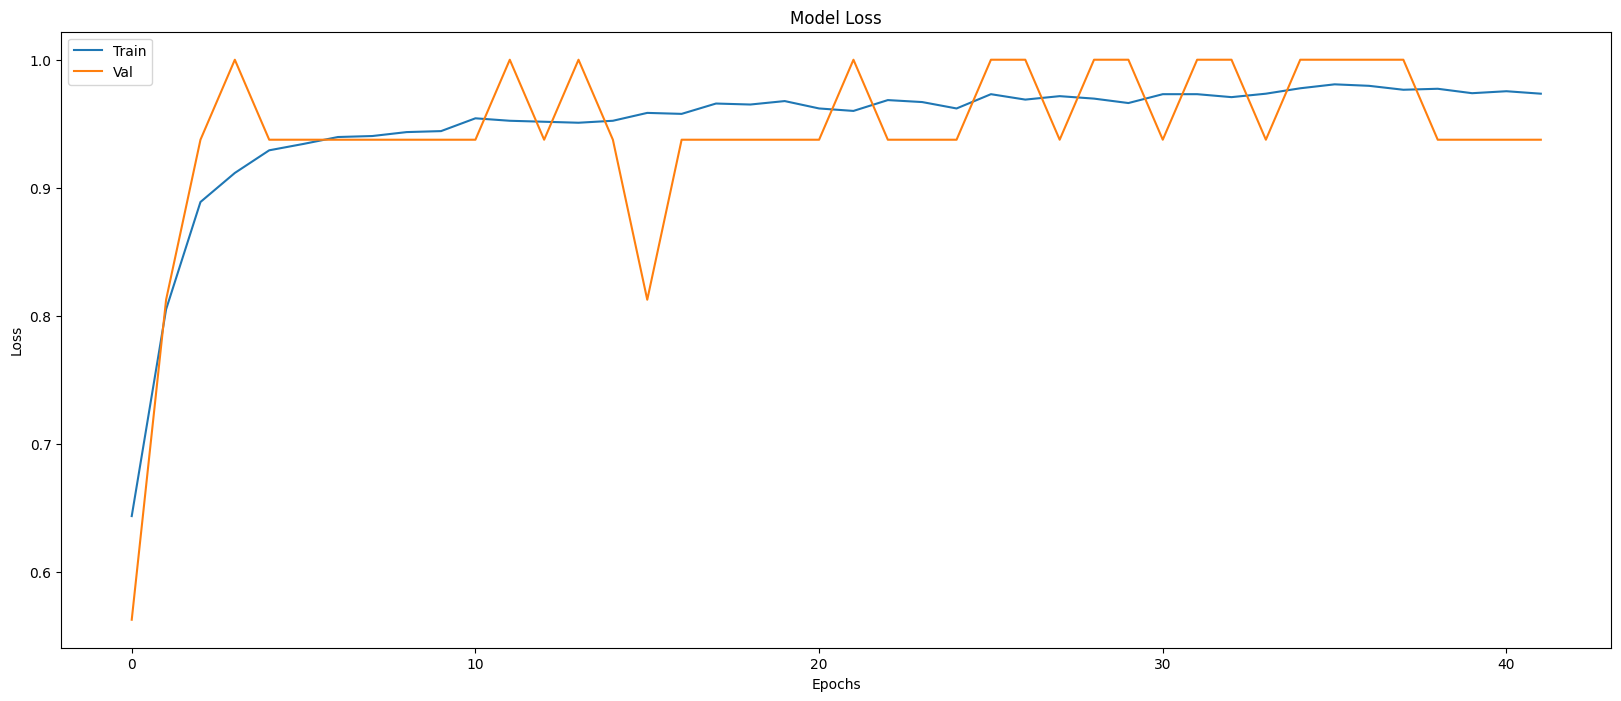

In [13]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(testdata)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9106 - loss: 0.3471
Test Loss: 0.2666666805744171
Test Accuracy: 0.9310897588729858


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step


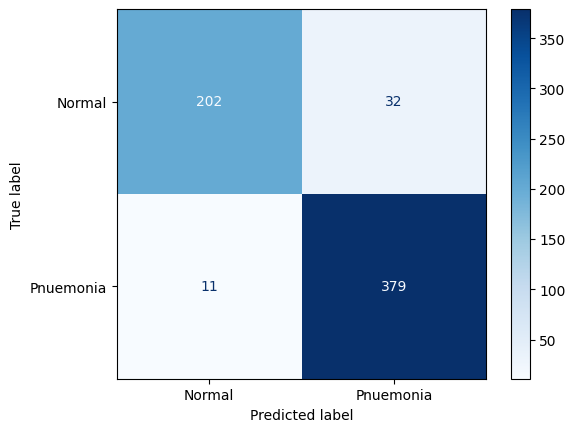

In [15]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
#confusion matrix
true_labels=testdata.classes

prediction=model.predict(testdata)
predicted_labels=(prediction>0.5).astype(int).flatten()

conf_matrix=confusion_matrix(true_labels,predicted_labels)
disp=ConfusionMatrixDisplay(conf_matrix,display_labels=['Normal','Pnuemonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
#Classification report
print("Classification Report")
print(classification_report(true_labels,predicted_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       234
           1       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



In [17]:
y_pred_prob=model.predict(testdata)
if y_pred_prob.shape[1] > 1:  
    y_pred_prob = y_pred_prob[:, 1]  # Take the probability for class 1 (Pneumonia)
else:
    y_pred_prob = y_pred_prob.flatten()  # If binary, the array may already be 1D


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step


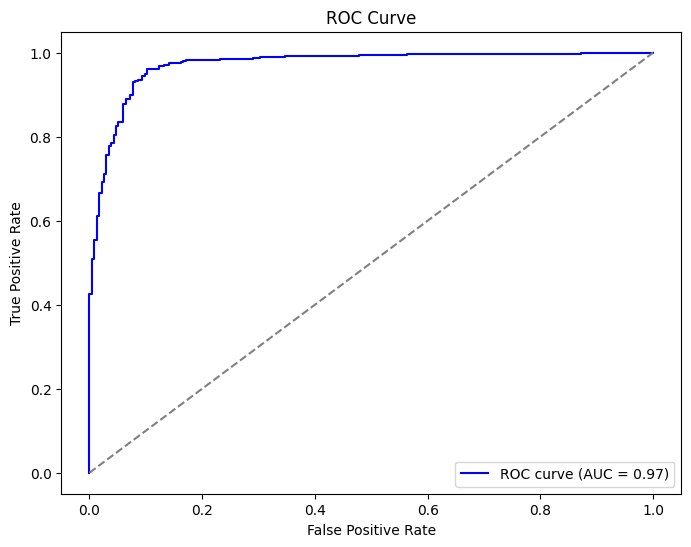

In [18]:
from sklearn.metrics import auc,roc_curve
#tpr=True positive rate : should be high 
#fpr=false positive rate : should be low i.e lower false prediction

fpr, tpr, thresholds = roc_curve(true_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
model.save('model_VGG16.keras')